In [177]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark import SparkContext

# Pour run sur le cluster
# spark-submit --master yarn --packages com.databricks:spark-xml_2.11:0.6.0 test1.py

# Pour choisir les parametres du cluster
# https://spoddutur.github.io/spark-notes/distribution_of_executors_cores_and_memory_for_spark_application.html

In [48]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.7.0 pyspark-shell'

In [49]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [ ]:
r2 = spark.read.format("xml") \
    .option("rowTag","release") \
    .load("releases_small.xml")

In [519]:
r2.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- _id: long (nullable = true)
 |-- _status: string (nullable = true)
 |-- artists: struct (nullable = true)
 |    |-- artist: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- anv: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- join: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- role: string (nullable = true)
 |    |    |    |-- tracks: string (nullable = true)
 |-- companies: struct (nullable = true)
 |    |-- company: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- catno: string (nullable = true)
 |    |    |    |-- entity_type: long (nullable = true)
 |    |    |    |-- entity_type_name: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- resource_url:

In [321]:
## Number of releases per year

def sum_col(df, col):
    # df --> DataFrame
    # col --> str (column name)
    # Computes the sum of values in col
    return df.select(F.sum(col)).collect()[0][0]

releases = r2.select(F.year(F.to_date(r2.released)).alias('year'))
release_count = releases.groupBy('year') \
             .agg(count("*").alias('numb_rel'))
release_count = release_count.fillna(0)

# Check number of releases :
sum_col(release_count,'numb_rel')

# Number of releases with no year associated
release_count.where(release_count.year==0).show()

174

In [ ]:
## Use the csv generated on the cluster
df = pd.read_csv('years.csv',header=None,names = ['year', 'nrel']).sort_values(by=['year'])
df_clean = df[df.year > 0]

df_clean.describe()
plt.plot(df_clean.year[:-2],np.log(df_clean.nrel[:-2]))

## Ratio of nan-year release to total number of releases
nan_year_rel = df.sort_values(by=['year'])[0:2].nrel.sum()
total_rel = df.nrel.sum()

In [520]:
## Evolution of genres
df_genres = r2.select(explode(r2.genres.genre).alias("genre"), \
                      F.year(F.to_date(r2.released)).alias('year')) \
              .groupBy('year','genre') \
              .agg(count("*").alias('numb_rel'))
df_genres.show()

+----+--------------------+--------+
|year|               genre|numb_rel|
+----+--------------------+--------+
|2010|          Electronic|       1|
|1929|                 Pop|       1|
|1999|                Rock|       1|
|2011|                 Pop|       1|
|2008|Folk, World, & Co...|       1|
|1992|               Blues|       1|
|2004|                 Pop|       1|
|1954|               Blues|       1|
|1929|                Jazz|       1|
|1993|         Funk / Soul|       1|
|2001|                Rock|       1|
|1991|          Electronic|       1|
|1995|Folk, World, & Co...|       1|
|null|               Latin|       1|
|2008|                Rock|       2|
|1958|           Classical|       1|
|1985|                 Pop|       1|
|null|                Rock|       2|
|null|         Funk / Soul|       2|
|2004|                Jazz|       1|
+----+--------------------+--------+
only showing top 20 rows



In [575]:
## Use the csv generated on the cluster
df = pd.read_csv('genres.csv',header=None,names = ['year', 'genre','numb_rel']).sort_values(by=['genre','year'])
df_clean = df[df.year > 0]

ymin = df_clean.year.min()
ymax = df_clean.year.max()
years = np.arange(ymin,ymax)

correct_year1 = df.year > 0
correct_year2 = df.year < 2019

genres = df.genre.unique()

n_genres = len(genres)
n_years = len(years)

data = np.zeros([n_genres,n_years])
l=0
%matplotlib qt
for i,genre in enumerate(genres):

    condition = df.genre == genre


    df_genre = df[condition & correct_year1 & correct_year2]
    df_genre.set_index('year')
    new_index = pd.Index(years, name="year")
    df_genre_clean = df_genre.set_index("year").reindex(new_index).fillna(0)
    data[i,:] = df_genre_clean.numb_rel.to_numpy()

plt.stackplot(years,data,labels=genres)  
plt.legend(loc='upper left')
plt.plot()


[]

C:\Programmes\Anaconda\envs\ADA\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[]

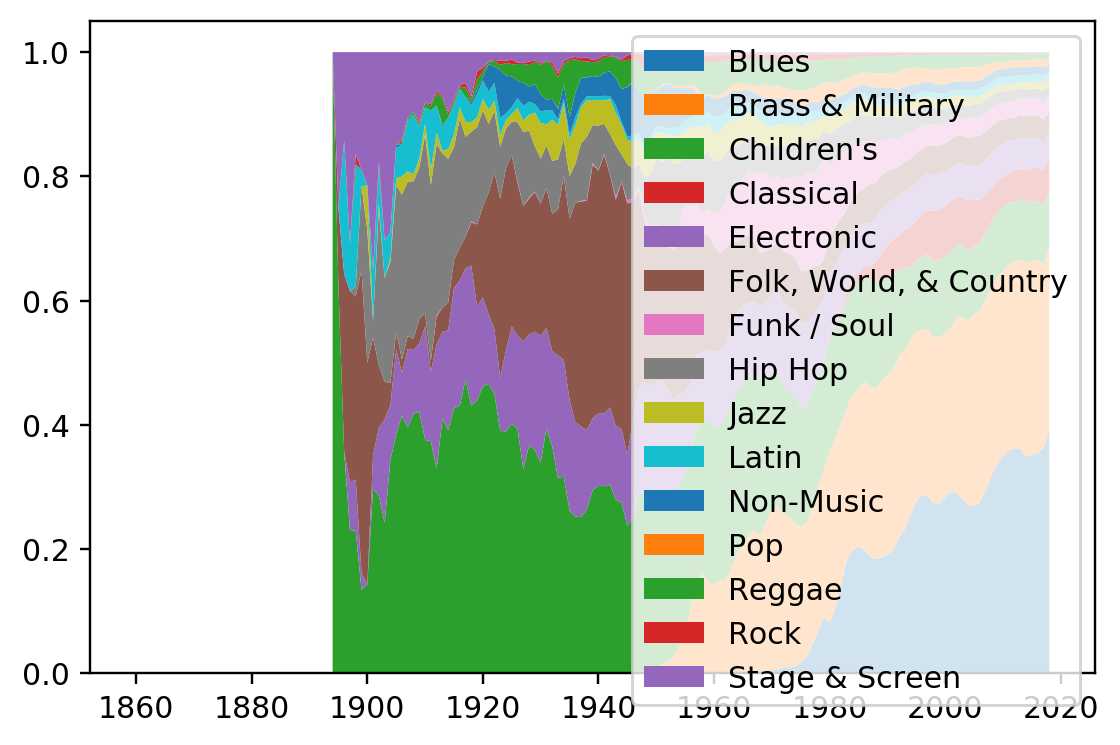

In [445]:
#Normalize data (to have genre repartition in percentage)
data_norm = np.divide(data,data.sum(axis=0))
# Sort by ascending values for 2019
idx = np.flip(data_norm[:,-1].argsort())
data_norm = data_norm[idx]

plt.stackplot(years,data_norm,labels=genres)  
plt.legend(loc='best')
plt.plot()

In [ ]:
r = spark.read.format("xml") \
    .option("rowTag","master") \
    .load("/datasets/discogs/discogs_20190101_masters.xml") \
    .sample(False, 0.01)


In [522]:

df_styles = r2.select(F.year(F.to_date(r2.released)).alias('year'), \
                     F.explode(r2.genres.genre).alias("genre"), \
                     'styles').filter(F.col('genre') == 'Electronic') \
                         .select('year',F.explode(r2.styles.style).alias('style')) \
                         .groupBy('year','style') \
                         .agg(count("*").alias('numb_rel')).fillna(0, subset = ['year']).show()


+----+----------------+
|year|           style|
+----+----------------+
|2005|Modern Classical|
|2005|         Ambient|
|2008|        Abstract|
|2008|          Techno|
|2008|    Experimental|
|2008|         Ambient|
|2008|    Dark Ambient|
|2008|         Minimal|
|2016|         Ambient|
|2016|           Drone|
|1993|      Deep House|
|2000|         Electro|
|2011|           House|
|2011|      Tech House|
|2015|         Ambient|
|2015|          Techno|
|2017|      Deep House|
|2017|           Disco|
|2017|       Downtempo|
|2017|           House|
+----+----------------+
only showing top 20 rows

+----+-----------------+--------+
|year|            style|numb_rel|
+----+-----------------+--------+
|   0|        Synth-pop|       2|
|2014|Power Electronics|       1|
|2001|          Ambient|       1|
|1999|      Drum n Bass|       1|
|1995|           Trance|       1|
|2001|            House|       1|
|1997|        Downtempo|       1|
|1999|              Dub|       4|
|   0|           Breaks|

In [583]:
## Use the csv generated on the cluster
df = pd.read_csv('styles.csv',header=None,names = ['year', 'style','numb_rel']).sort_values(by=['style','year'])
df_clean = df[df.year > 0]

ymin = df_clean.year.min()
ymax = df_clean.year.max()
years = np.arange(ymin,ymax)

correct_year1 = df.year > 0
correct_year2 = df.year < 2019

styles = df['style'].unique()

n_styles = len(styles)
n_years = len(years)

data = np.zeros([n_styles,n_years])

%matplotlib qt

for i,style in enumerate(styles):

    condition = df['style'] == style


    df_style = df[condition & correct_year1 & correct_year2]
    df_style.set_index('year')
    new_index = pd.Index(years, name="year")
    df_style_clean = df_style.set_index("year").reindex(new_index).fillna(0)
    data[i,:] = df_style_clean.numb_rel.to_numpy()

#plt.stackplot(years,data,labels=styles)  
#plt.legend(loc='upper left')
#plt.plot()

In [596]:
#Keep only most used styles
n_keep = 15;
idx = np.flip(data[:,-3].argsort())
data_keep = data[idx][1:n_keep]
styles_keep = styles[idx][1:n_keep]

#Normalize data (to have genre repartition in percentage)
data_norm = np.divide(data_keep,data_keep.sum(axis=0))
# Sort by ascending values for 2019

plt.stackplot(years,data_norm,labels=styles_keep)  
plt.legend(loc='upper left')
plt.plot()

C:\Programmes\Anaconda\envs\ADA\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[]

In [631]:
## Formats
df_formats = r2.select(F.year(F.to_date(r2.released)).alias('year'), \
                     F.explode(r2.formats.format._name).alias("format")) \
                         .groupBy('year','format') \
                         .agg(F.count("*").alias('numb_rel')).fillna(0, subset = ['year']).show()

+------+----+
|format|year|
+------+----+
| Vinyl|1999|
| Vinyl|null|
| Vinyl|2000|
| Vinyl|1996|
| Vinyl|2001|
| Vinyl|null|
| Vinyl|2000|
| Vinyl|1995|
| Vinyl|null|
|    CD|1996|
| Vinyl|null|
| Vinyl|null|
| Vinyl|2001|
| Vinyl|1991|
| Vinyl|1999|
|    CD|1999|
| Vinyl|1993|
|    CD|1995|
| Vinyl|1998|
| Vinyl|null|
+------+----+
only showing top 20 rows

+----+---------+--------+
|year|   format|numb_rel|
+----+---------+--------+
|1993|    Vinyl|       2|
|1999|    Vinyl|       7|
|1994|    Vinyl|       2|
|2014| Cassette|       1|
|2013|All Media|       1|
|2017|       CD|       1|
|1982|    Vinyl|       1|
|   0|    Vinyl|      17|
|1968|    Vinyl|       1|
|2013|       CD|       3|
|2014|    Vinyl|       2|
|1989|      CDV|       1|
|1984|    Vinyl|       1|
|2004|       CD|       3|
|2008|       CD|       3|
|2017|     File|       1|
|2000|    Vinyl|       3|
|2009|      CDr|       1|
|2013|     File|       1|
|2011|       CD|       2|
+----+---------+--------+
only showing t

In [639]:
## Use the csv generated on the cluster
df = pd.read_csv('formats.csv',header=None,names = ['year', 'format','numb_rel']).sort_values(by=['format','year'])
df_clean = df[df.year > 0]

ymin = df_clean.year.min()
ymax = df_clean.year.max()
years = np.arange(ymin,ymax)

correct_year1 = df.year > 0
correct_year2 = df.year < 2019

formats = df['format'].unique()

n_formats = len(formats)
n_years = len(years)

data = np.zeros([n_formats,n_years])

%matplotlib qt

for i,f in enumerate(formats):

    condition = df['format'] == f


    df_format = df[condition & correct_year1 & correct_year2]
    df_format.set_index('year')
    new_index = pd.Index(years, name="year")
    df_format_clean = df_format.set_index("year").reindex(new_index).fillna(0)
    data[i,:] = df_format_clean.numb_rel.to_numpy()

#Keep only most used formats
n_keep = 10;
idx = np.flip(data[:,-3].argsort())
data_keep = data[idx][1:n_keep]
formats_keep = formats[idx][1:n_keep]

#Normalize data (to have genre repartition in percentage)
data_norm = np.divide(data_keep,data_keep.sum(axis=0))
# Sort by ascending values for 2019

plt.stackplot(years,data_norm,labels=formats_keep)  
plt.legend(loc='upper left')
plt.plot()

C:\Programmes\Anaconda\envs\ADA\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


[]

In [112]:
import json
schema = r1.schema
jsonString = schema.json()
with open('schema.txt', 'w') as outfile:
    json.dump(jsonString, outfile)

In [113]:

from pyspark.sql.types import StructType
with open('schema.txt', 'r') as file:
    schema_json = json.load(file)    
new_schema = StructType.fromJson(json.loads(schema_json))
r1 = spark.read.format("xml") \
    .option("rowTag","label") \
    .schema(new_schema) \
    .load("discogs_20190101_labels.xml") \